In [18]:
import jax.numpy as np
from jax import random
from jax import vmap

import functools

from utils import get_toy_data
from models import homoscedastic_model
from train import train_model
import nt_predict_copy
import config

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')
import matplotlib
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt

In [69]:
def format_plot(x=None, y=None):
    ax = plt.gca()
    if x is not None:
        plt.xlabel(x, fontsize=20)
    if y is not None:
        plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
        shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()
    
def plot_fn(train, test, *fs):
    train_xs, train_ys = train

    plt.plot(train_xs, train_ys, 'go', markersize=7, label='train')

    if test != None:
        test_xs, test_ys = test
        plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

        for f in fs:
            plt.plot(test_xs, f(test_xs), '-', linewidth=3)
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-1.5, 1.5])

    format_plot('$x$', '$f$')


In [27]:
key = random.PRNGKey(10)

In [28]:
model_config = config.get_model_config('default')

In [29]:
model_config

{'W_std': 1.5, 'b_std': 0.05, 'width': 512, 'depth': 2}

In [30]:
_, _, kernel_fn = homoscedastic_model( parameterization = 'ntk', **model_config)

In [31]:
data_config = config.get_data_config('default')

In [32]:
train_data, test_data = get_toy_data(key, config.NOISE_SCALE, **data_config)

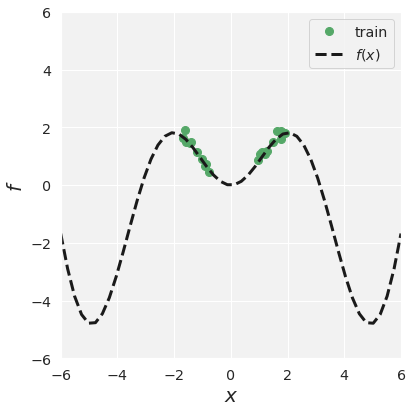

In [64]:
plot_fn(train_data, test_data)
format_plot('$x$', '$f$')
plt.legend()

plt.xlim([-6., 6.])
plt.ylim([-6., 6.])

finalize_plot((1,1))

In [8]:
analytic_ntkgp_moments, analytic_nngp_moments = nt_predict_copy.gp_inference_copy(
    kernel_fn = kernel_fn,
    x_train = train_data.inputs,
    y_train = train_data.labels,
    x_test = test_data.inputs,
    get = ['ntk', 'nngp'],
    diag_reg = config.NOISE_SCALE**2,
    compute_cov = True
)

/home/bobby/github/bayesian-ntk/bntk-env/lib/python3.7/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [9]:
results_dict = {
    'NTKGP analytic': analytic_ntkgp_moments,
    'NNGP analytic': analytic_nngp_moments
}

In [10]:
ensemble_methods_list = ['Deep ensemble', 'RP-param', 'NTKGP-param']

In [14]:
train_config = config.get_train_config('default')
ensemble_key = random.split(key, config.ENSEMBLE_SIZE)
train_baselearner = lambda key, train_method: train_model(key, train_method, train_data, test_data, parameterization = 'standard', **train_config)
train_ensemble = lambda train_method: vmap(train_baselearner, (0, None))(ensemble_key, train_method)

for method in ensemble_methods_list:
    method_input_str = config.method_input_dict[method]
    baselearners_test_pred = train_ensemble(method_input_str)
    ensemble_mean = np.mean(baselearners_test_pred, axis = 0).reshape(-1,)
    ensemble_var = np.var(baselearners_test_pred, axis = 0, ddof = 1).reshape(-1,)
    ensemble_std = np.sqrt(ensemble_var + config.NOISE_SCALE ** 2)
    results_dict.update(
        {
            method: config.Gaussian(ensemble_mean, ensemble_std)
        }
    )


step  0
step  0
step  0


In [38]:
plot_method_list = ['NNGP analytic'] + ensemble_methods_list

In [39]:
results_dict['NNGP analytic'].standard_deviation

DeviceArray([0.40142822, 0.41649628, 0.4329834 , 0.45131683, 0.4718933 ,
             0.49465942, 0.5203171 , 0.54927826, 0.58177185, 0.61865234,
             0.660347  , 0.70767975, 0.7613678 , 0.8217392 , 0.88908386,
             0.96242523, 1.0392914 , 1.1133194 , 1.1716156 , 1.1901321 ,
             1.1289749 , 0.9364853 , 0.5912514 , 0.25585938, 0.5775833 ,
             1.8073254 , 2.024559  , 1.7102661 , 1.4262009 , 1.2832184 ,
             1.248703  , 1.2741776 , 1.3258667 , 1.3850021 , 1.4425659 ,
             1.4945602 , 1.5400085 , 1.5788422 , 1.6117783 , 1.639534  ,
             1.6628952 , 1.6825256 , 1.6990204 , 1.71315   , 1.7249908 ,
             1.7349014 , 1.743393  , 1.7505951 , 1.7566528 , 1.7619781 ],            dtype=float32)

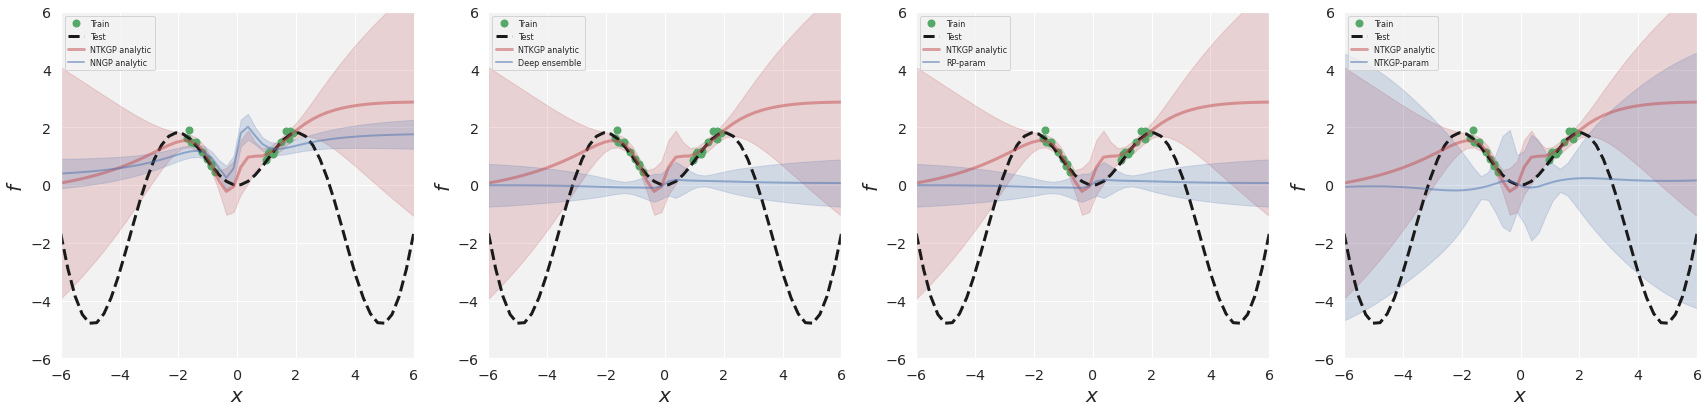

In [74]:
legend = functools.partial(plt.legend, fontsize=8)
for plt_idx in range(1, 5):
    plt.subplot(1, 4, plt_idx)
    plot_fn(train_data, test_data)
    
    ntkgp_moments = results_dict['NTKGP analytic']
    ntkgp_means = ntkgp_moments.mean
    ntkgp_stds = ntkgp_moments.standard_deviation
    plt.plot(test_data.inputs, ntkgp_means, 'r-', linewidth = 3, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        ntkgp_means - 2 * ntkgp_stds,
        ntkgp_means + 2 * ntkgp_stds,
        color='r',
        alpha = 0.2
    )
    method = plot_method_list[plt_idx - 1]
    method_moments = results_dict[method]
    method_means = method_moments.mean
    method_stds = method_moments.standard_deviation
    plt.plot(test_data.inputs, method_means, 'b-', linewidth = 2, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        method_means - 2 * method_stds,
        method_means + 2 * method_stds,
        color='b',
        alpha = 0.2
    )
    
    legend(['Train', 'Test', 'NTKGP analytic', method], loc = 'upper left')
    plt.xlim([-6., 6.])
    plt.ylim([-6., 6.])
    format_plot('$x$', '$f$')
finalize_plot((4,1))
#     plt.plot(test_data.inputs, )